## Part 1: Heart Disease Prediction Dataset (30 Pts)
### Q1: Exploratory Data Analysis (5 Pts)

Get familiar with the dataset by exploring the different features, their distribution, and the labels. Check for common pitfalls like missing or nonsensical data, unusual feature distribution, outliers, or class imbalance, and describe how to handle them. After having familiarized yourself with the data, explain how you preprocess the dataset for the remaining tasks of part 1. Interpretability and explainability aim at gaining more insights about the data than just optimizing predictive performance. A first simple step is to have a look at the (linear) dependencies of the variables. Visualize the pairwise correlation matrix and describe which features seem to be important for predicting the label.

### Q2: Logistic Lasso Regression (5 Pts)

By design, linear models are interpretable due to the weights that intuitively provide feature importance values. Further, we can perform l 1 regularization to sparsify weights, allowing us to understand which features do not contribute to the outcome. For this question, fit a Lasso regression model with l 1 regularization on the dataset. What preprocessing step is crucial to ensure comparability of feature coefficients? Provide performance metrics such as f1-score or balanced accuracy to quantify the performance of this model. Visualize the importance of the different features and present how they contribute to the model's output. Finally, argue for or against fitting a logistic regression using only the important variables, as determined by the Lasso model, to arrive at the final coefficients instead of keeping the coefficients of the Lasso model.

### Q3: Decision Trees (3 Pts)

Like linear models, decision trees are intrinsically interpretable models by nature. For a given output, we can retrace every decision that led to the final prediction by following the path of a sample along the edges of the tree. Further, the models' impurity measure allows us to quantify feature importance within the dataset. As in the previous question, train a decision tree on the dataset and report classification performance on the test set. Visualize the influence of the different features according to the Gini importance.

### Q4: Multi-Layer Perceptrons(7 Pts)

While often reaching superior performance, MLPs are generally hard to interpret, and it is not straightforward to see what is happening within these models. We thus opt for post-hoc explainability methods such as SHAP1 . Post-hoc explainability methods typically use some procedure during inference to find the feature importance per sample. Similar to Q2 and Q3, implement a simple MLP, train it on the dataset, and report test set performance. Make sure to report the architecture and optimization procedure you used for training.

Further, visualize SHAP explanations of the outputs of four positive and negative samples and feature importances of the overall model. Are feature importances consistent across different predictions and compared to overall importance values? Elaborate on your findings!

Hint: There is an excellent SHAP library for python that provides many SHAP algorithms and visualizations out of the box.

### Challenge 1: Neural Additive Models 2 (10 Pts)

Another way to make deep models more interpretable is by careful design of the architecture. One example of such a model is the Neural Additive Model (NAM), which is an instance of the class of Generalized Additive Models 3 (GAM). Read the paper about NAMs, implement the model, and train it on the dataset. Like Q2-4, provide performance metrics on the test set. Similar to Q4, visualize the feature importances of four positive and four negative samples. Are the feature importances similar for different samples? Do the feature importances found with NAMs differ from the ones in Q2-4, or are they consistently the same? Conceptually, how does the model compare to Logistic Regression and MLPs? Why are NAMs more interpretable than MLPs despite being based on non-linear neural networks?


In [4]:
# Q1
import pandas as pd 
import numpy as np

# Load data
train_val_split = pd.read_csv('/Users/daniel/MLHC23/MLHC/heart_failure_data/train_val_split.csv')
test_split = pd.read_csv('/Users/daniel/MLHC23/MLHC/heart_failure_data/test_split.csv')

In [5]:
# Check shape of data
print('Shape of train_val_split:', train_val_split.shape, '\nShape of test_split:', test_split.shape, '\ntrain_val_split is 4x the size of test_split')

Shape of train_val_split: (734, 12) 
Shape of test_split: (184, 12) 
train_val_split is 4x the size of test_split


In [6]:
train_val_split.head

<bound method NDFrame.head of      Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     37   M           ATA        130          283          0         ST   
2     48   F           ASY        138          214          0     Normal   
3     54   M           NAP        150          195          0     Normal   
4     39   M           NAP        120          339          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
729   41   M           ATA        120          157          0     Normal   
730   57   F           ASY        140          241          0     Normal   
731   45   M            TA        110          264          0     Normal   
732   68   M           ASY        144          193          1     Normal   
733   57   M           ASY        130          131          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisease

In [7]:
# Check datatypes
train_val_split.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

### What are nonsensical values?

**Sensible ranges:** 

*What is physically the limit*

Cholesterol: 70 < x > 600


RestingBP: 60 < x > 200


MaxHR: 60 < x > 220

-> Our data is not out of bounds

In [8]:
train_val_split['MaxHR'].value_counts()

150    37
140    35
120    31
130    25
170    19
       ..
63      1
77      1
91      1
190     1
194     1
Name: MaxHR, Length: 115, dtype: int64

In [9]:
# Analyze data graphically: Check distributions

# MaxHR distribution
import plotly.express as px 
MaxHR_counts = train_val_split['MaxHR'].value_counts()
fig_MaxHR = px.bar(x=MaxHR_counts.index, y=MaxHR_counts.values, title='MaxHR distribution')
fig_MaxHR.show()

In [10]:
train_val_split['RestingBP'].value_counts() # Detects outliers at value 1 -> need to be removed

120    108
130     90
140     88
110     48
150     41
      ... 
185      1
0        1
116      1
154      1
148      1
Name: RestingBP, Length: 64, dtype: int64

In [11]:
# RestingBP distribution
RestingBP_counts = train_val_split['RestingBP'].value_counts()
fig_RestingBP = px.bar(x=RestingBP_counts.index, y=RestingBP_counts.values, title='RestingBP distribution')
fig_RestingBP.show()

In [12]:
# Cholesterol distribution
# Since there are lots of zero entries in this column, they need to be removed first
train_val_split = train_val_split[train_val_split['Cholesterol']!=0] # This removes the zero entries from 'Cholesterol' column
Cholesterol_counts = train_val_split['Cholesterol'].value_counts()
fig_Cholesterol = px.bar(x=Cholesterol_counts.index, y=Cholesterol_counts.values, title='Cholesterol distribution')
fig_Cholesterol.show()

In [13]:
# Age distribution
Age_counts = train_val_split['Age'].value_counts()
fig_Age = px.bar(x=Age_counts.index, y=Age_counts.values, title='Age distribution')
fig_Age.show()

In [14]:
# Oldpeak distribution
# Here I'm not sure if it's sensible to remove the zero entries.
Oldpeak_counts = train_val_split['Oldpeak'].value_counts()
fig_Oldpeak = px.bar(x=Oldpeak_counts.index, y=Oldpeak_counts.values, title='Oldpeak distribution')
fig_Oldpeak.show()

In [15]:
# Explore outliers
train_val_split['Oldpeak'].value_counts()

 0.0    261
 1.0     51
 2.0     42
 1.5     29
 3.0     19
 1.2     18
 0.2     15
 0.8     14
 1.4     12
 0.6     12
 1.8     10
 2.5      9
 0.5      9
 1.6      8
 0.1      8
 0.3      7
 4.0      7
 0.4      6
 2.6      5
 1.9      5
 1.3      4
 2.8      4
 1.7      4
 3.6      4
 2.2      4
 3.4      3
 1.1      3
 2.4      3
 2.3      2
 0.9      2
 4.2      2
 3.1      1
 3.5      1
-0.1      1
 0.7      1
 3.2      1
 5.6      1
 2.1      1
 2.9      1
 5.0      1
 6.2      1
 4.4      1
Name: Oldpeak, dtype: int64

In [16]:
# Transform Strings into Numeric values for later classification
from sklearn.preprocessing import LabelEncoder

cols_to_encode = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']  

for col in cols_to_encode:
    train_val_split[col] = LabelEncoder().fit_transform(train_val_split[col])

train_val_split.head(8)


/var/folders/hz/h28mpvb54vlc3_s3yqxl8g880000gn/T/ipykernel_19791/620908888.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/hz/h28mpvb54vlc3_s3yqxl8g880000gn/T/ipykernel_19791/620908888.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/hz/h28mpvb54vlc3_s3yqxl8g880000gn/T/ipykernel_19791/620908888.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,37,1,1,130,283,0,2,98,0,0.0,2,0
2,48,0,0,138,214,0,1,108,1,1.5,1,1
3,54,1,2,150,195,0,1,122,0,0.0,2,0
4,39,1,2,120,339,0,1,170,0,0.0,2,0
5,45,0,1,130,237,0,1,170,0,0.0,2,0
6,54,1,1,110,208,0,1,142,0,0.0,2,0
7,37,1,0,140,207,0,1,130,1,1.5,1,1


In [21]:

# Create Correlation Matrices and visualize with heatmaps
# Code source https://towardsdatascience.com/how-to-use-pairwise-correlation-for-robust-feature-selection-20a60ef7d10 
# Adapted to current problem

import seaborn as sns
import matplotlib.pyplot as plt

def correlation_matrix(df: pd.DataFrame):
    """
    A function to calculate and plot
    correlation matrix of a DataFrame.
    """
    # Create the matrix
    matrix = df.corr()
    
    # Create cmap
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
    # Create a mask
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    
    # Make figsize bigger
    fig, ax = plt.subplots(figsize=(16,12))
    
    # Plot the matrix
    _ = sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, ax=ax)

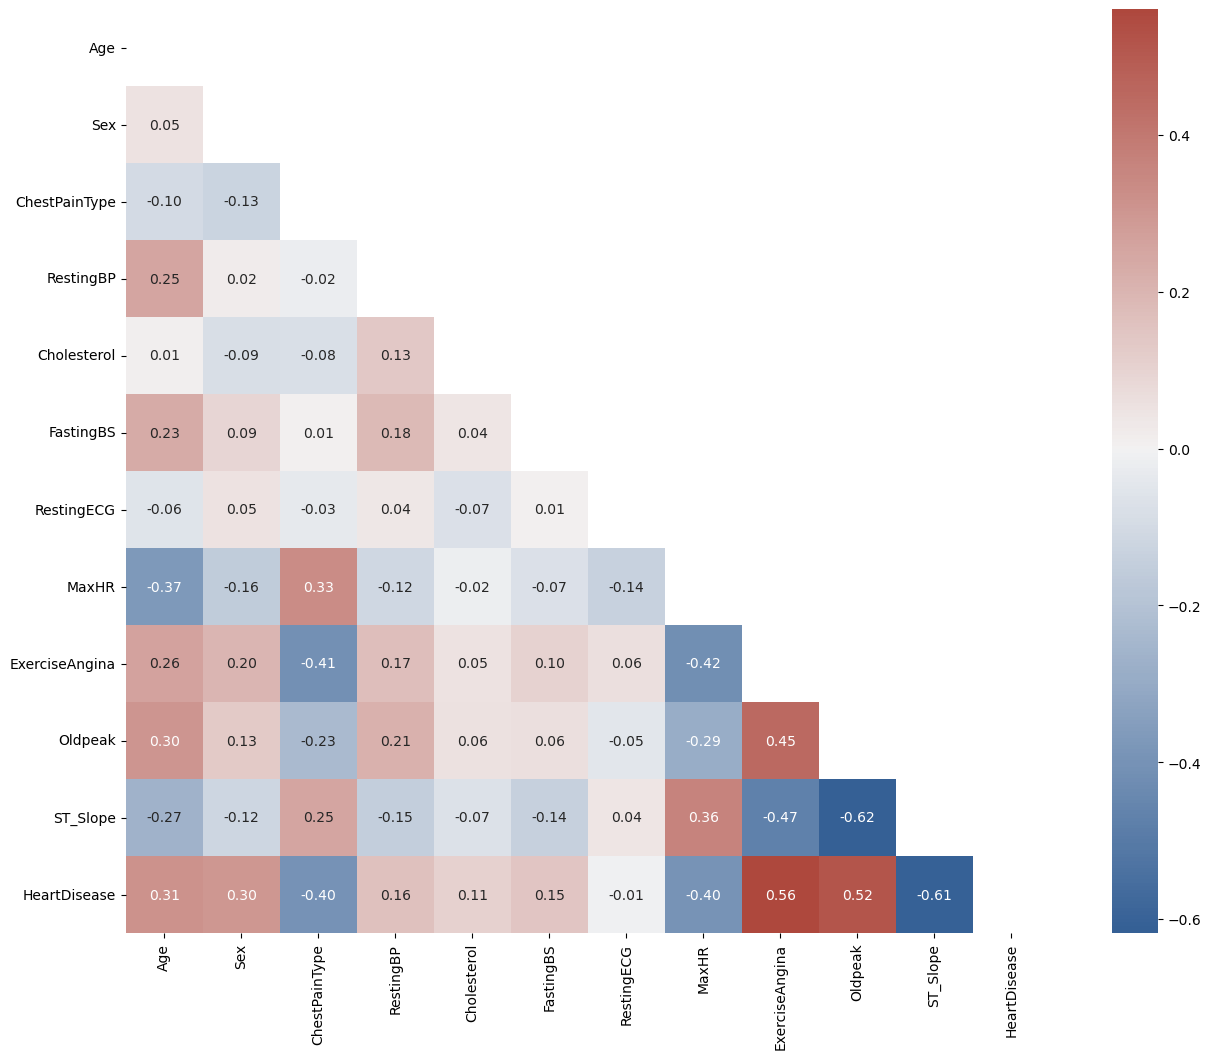

In [22]:
correlation_matrix(train_val_split)

## Part 2: Pneumonia Prediction Dataset (30 Pts)
### Q1: Exploratory Data Analysis (4 Pts)

Download and explore the data. Explore label distribution and qualitatively describe the data by plotting healthy and pneumonia samples. Do you see visual differences between healthy and disease samples? Do you find sources of bias that could influence model performance? How do you preprocess the data for your further analysis?

### Q2: CNN Classifier (4 Pts)

In Q3 and Q4, we aim to use post-hoc explainability methods for visualizing the parts of the image that are important for the prediction of a model. Thus, design a small CNN classifier for the dataset and report its performance on a test set. Make sure to elaborate on your architecture and training details.

### Q3: Integrated Gradients 5 (4 Pts)

Like MLPs, CNNs perform very well in tasks like classification but lack interpretability due to their black-box nature. Again, post-hoc explainability methods are thus suitable alternatives. One class of post-hoc procedures specific to image data are methods generating attribution maps, which try to highlight the most important regions on which the CNN bases its predictions. For this part of the assignment, implement the integrated gradient method. Visualize attribution maps of five healthy and five disease test samples. Do the maps highlight sensible regions? Are attributions consistent across samples? Do they match potential observations from Q1?

### Q4: Grad-CAM 6 (5 Pts)

Grad-CAM is another post-hoc method that generates attribution maps. Like in Q3, implement the method and visualize attribution maps of five healthy and five disease test samples. Do the maps highlight sensible regions? Are attributions consistent across samples? Compare your findings with Q3.

### Q5: Data Randomization Test 7 (3 Pts)

Recently, the paper “Sanity Checks for Saliency Maps.” introduced the data randomization test to check how trustworthiness of the saliency maps of specific methods. They propose to retrain the classifier on the train set when randomly permuting labels of all samples. Then, they compare the saliency maps on test samples for the perturbed and unperturbed classifiers. We expect the map to change if an attribution map accurately captures the relationship between instances and their labels. Conversely, if the attribution map captures another concept, e.g., acts like an edge detector independent of the label, we expect the maps to stay the same. Retrain your CNN on random training labels and perform the Data randomization Test for both Integrated Gradients and Grad-CAM. Do they pass or fail? Elaborate and visualize your findings!

### Challenge 2: Prototype Learning (10 Pts)

A radically different idea for interpretable classification is finding prototypical samples for each class. Then, in addition to the prediction, we can return the prototype most similar to the input. This idea was explored in the paper “Examples are not Enough, Learn to Criticize! Criticism for Interpretability”8 . They provide a method that allows you to extract representative prototypes from a given dataset by using the maximum mean discrepancy (MMD) measure as a distance function and introducing a kNN-like classifier. After reading the paper, we ask you to implement their method in two steps:

1. Implement the “Nearest Prototype Classifier” described in Section 5 of the paper. For now, set the set of prototypes S to be random points of the training set. Report the classification performance of this model on the test set.

2. Implement the function Jb (S) (Section 3) and select prototypes S through their greedy algorithm (Algorithm 1). Refit the classifier, this time with the selected prototypes, and compare classification performance to random prototypes. Does the result behave as you expected? Why or why not? Visualize five healthy and five disease prototypes. Do you find representative class patterns among them? Would you say they look prototypical?

How could you improve performance beyond simply applying kNN to the raw images? Compare this type of interpretable method to the previously seen saliency maps. Which method do you think is more useful? Can you think of scenarios where one is more valuable than the other?

Remark: The proposed method can be computationally inefficient. Keep that in mind and implement the method as efficiently as possible. Also, feel free to subsample the training set and resize images to, e.g., 128x128. Additionally, you may find it helpful to transform the RGB images to grayscale by setting pixel values to 0.299*red+0.587*green+0.114*blue.

Optional Task: The authors further propose to return a set of so-called criticisms: samples that belong to a class but have unique characteristics, making them less representative of the dataset. If you are interested, you can additionally implement and explore criticism and see whether you find them a valuable interpretable component. Note that this is not required to get full points for this task.